In [1]:
import numba
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mol2vec import features
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from gensim.models import word2vec
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

Traceback (most recent call last):
  File "/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


# Linear regression

In this notebook, we're going to perform some rudimentary checks to make sure our `mol2vec` model is working in a way we expect it to by using the predicted vectors/features to predict the abundances of cyanopolyynes in TMC-1. The idea behind this is that the cyanopolyynes extends mainly along one dimension/feature, which is the number of carbons. The first thing we will do is to use principal components analysis to extract the most important features, in this case should correlate with the number of carbon atoms, and then use the lower dimensionality features to predict the column densities of the molecules.

This is also a good opportunity to test out the models we'll be considering: linear regression, $k$-nearest neighbors, and a Gaussian process with a simple radial basis kernel.

In [2]:
model = word2vec.Word2Vec.load("../../models/mol2vec_model.pkl")

In [3]:
@numba.jit(fastmath=True)
def cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))


@numba.jit(fastmath=True)
def pairwise_similarity(vectors):
    n = len(vectors)
    matrix = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(n):
            matrix[i,j] = cosine_similarity(vectors[i], vectors[j])
    return matrix


def smi_to_vector(smi: str, model):
    try:
        mol = Chem.MolFromSmiles(smi)
    except RuntimeError:
        mol = Chem.MolFromSmiles(smi, sanitize=False)
        mol.UpdatePropertyCache(strict=False)
        Chem.GetSymmSSSR(mol)
    # generate a sentence from rdkit molecule
    sentence = features.mol2alt_sentence(mol, radius=1)
    # generate vector embedding from sentence and model
    vector = features.sentences2vec([sentence], model)
    return vector

In [4]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

## See how PCA looks

Principal component analysis is a way to reduce the dimensionality/number of features: we have 300 in `mol2vec`, and we're not sure which ones correspond to the "number of carbons" dimension. The way PCA works is by determining projections of the feature space where the explained variance is maximized: in other words, _which axes/dimensions explain the most variation in the data_. For our select polyyne chains, the biggest difference between them all is the length of the carbon chain.

In [12]:
molecules = ["HCN", "HC3N", "HC5N", "HC7N", "HC9N"]

In [13]:
cyanopolyynes = tmc1_df.loc[tmc1_df["Formula"].isin(molecules)]

In [14]:
cyanopolyynes

,Molecule,Formula,SMILES,Column density (cm^-2),DOI,Isotopologue,Upper Limit,Notes,Vecs
51,Cyanoacetylene,HC3N,C#CC#N,1.750000e+14,10.3847/2041-8213/aba631,0,0,GOTHAM; analysis in Loomis 2020 but tabulated ...,"[0.033001095, -0.89367014, -1.2477198, -1.8944..."
53,Cyanodiacetylene,HC5N,C#CC#CC#N,6.690000e+13,10.3847/2041-8213/aba631,0,0,GOTHAM; analysis in Loomis 2020 but tabulated ...,"[-0.24897599, -2.1475952, -1.4807937, -2.30601..."
55,Cyanotriacetylene,HC7N,C#CC#CC#CC#N,3.650000e+13,10.3847/2041-8213/aba631,0,0,GOTHAM; analysis in Loomis 2020 but tabulated ...,"[-0.53095317, -3.4015205, -1.7138677, -2.71755..."
57,Cyanotetraacetylene,HC9N,C#CC#CC#CC#CC#N,2.160000e+13,NaN,0,0,GOTHAM; Loomis 2020,"[-0.8129304, -4.655446, -1.9469416, -3.1290882..."


In [15]:
# take 3 components: the number of components has to be fewer than the number of samples
pca_model = PCA(n_components=3)

In [16]:
cp_array = np.vstack(cyanopolyynes["Vecs"].to_list())

In [17]:
# the 2D array is number of samples x number of features
cp_array.shape

(4, 300)

In [18]:
# fit the PCA model
result = pca_model.fit(cp_array)

In [19]:
# this corresponds to the percentage of explained variance with the component
# number. PCA works to find the minimum number of components that explains the
# most variation in your data
result.explained_variance_ratio_

array([1.0000000e+00, 1.0197026e-14, 7.4460058e-15], dtype=float32)

In [20]:
# once we've fit the PCA model, we can transform the 300 dimensional vectors into
# the PCA projection
reduced = result.transform(cp_array)

In [21]:
# the result is nnumber of samples x number of dimensions
reduced.shape

(4, 3)

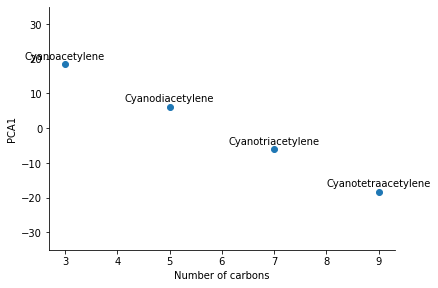

In [23]:
# if we plot out the first dimension, this we think should
# correspond to the number of carbons. This can be a little abstract to think about
fig, ax = plt.subplots()

n_carbon = np.arange(3, 11, 2)

ax.scatter(n_carbon, reduced[:,0])

# annotate the molecule names
for index, (_, row) in enumerate(cyanopolyynes.iterrows()):
    ax.text(
        n_carbon[index], reduced[index,0] + 1.5, row["Molecule"], horizontalalignment="center"
    )
fig.tight_layout()
ax.set(ylabel="PCA1", xlabel="Number of carbons", ylim=[-35., 35.])

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

This checks out! The first dimension indeed correlates with the number of carbons in the chain. This is just a sanity check to make sure the features our `mol2vec` model are producing actually makes sense to us.

## Linear regression with carbon chain abundances

To test how well this works, we can try and see how well the cyanopolyyne chain abundances decrease linearly.

In [24]:
model = LinearRegression()

In [28]:
# This is just to help conceptualize what we're doing
X = reduced
Y = cyanopolyynes["Column density (cm^-2)"]

In [29]:
# fit the linear model
fit_result = model.fit(X, Y)

### Plot the linear result

In [30]:
pred_Y = fit_result.predict(X)

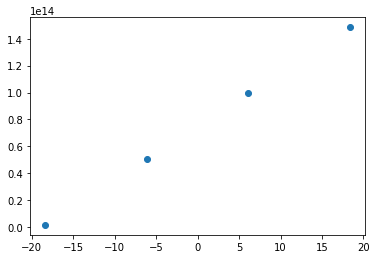

In [33]:
fig, ax = plt.subplots()

ax.scatter(X[:,0], pred_Y)

## k-nearest neighbors

In [103]:
n_neighbors = 3
knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

In [ ]:
knn_fit = knn_model.fit(X, Y)
knn_pred = knn_fit.predict(X)

## Gaussian process

In [108]:
# The RBF kernel has a "length_scale" parameter that defines how uncertain we think
# our data is. This is a tunable parameter.
kernel = RBF(length_scale=0.3)
gp_model = GaussianProcessRegressor(kernel)

In [ ]:
gp_fit = gp_model.fit(X, Y)
gp_pred = gp_fit.predict(X)

## Plot up all the results on the same graph